# Kinetics V

This lecture covers the kinetic analysis of data obtained in integral tubular reactors (plug flow or packed bed reactors). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as stats
from math import ceil, floor

## Example Problem 01

The following reaction is carried out in a Plug Flow Reactor operating at steady state.   

$$A \longrightarrow B$$

You measure the feed concentration of $A$ very accurately for this system, and you find it to be $C_{Af} = 0.209 \ \mathrm{mol \ L^{-1}}$. We vary feed volumetric flowrates while retaining $C_{Af}$ constant; this allows us to sample a large range of space times, $\tau$. For each space time, we measure the concentration of species $A$ in the reactor effluent, $C_A$. Data are compiled in the table below. 


|$\tau (\mathrm{s})$ | $C_A \ (\mathrm{mol \ L^{-1}})$ |
|:------------------:|:-------------------------------:|
|$0$                 | $2.16 \times 10^{-1}$           |
|$0.133$             | $2.04 \times 10^{-1}$           |
|$0.267$             | $1.98 \times 10^{-1}$           |
|$0.667$             | $2.01 \times 10^{-1}$           |
|$1.33$              | $1.68 \times 10^{-1}$           |
|$2.67$              | $1.52 \times 10^{-1}$           |
|$6.67$              | $1.22 \times 10^{-1}$           |
|$13.3$              | $1.02 \times 10^{-1}$           |
|$26.7$              | $6.84 \times 10^{-1}$           |
|$66.7$              | $4.46 \times 10^{-2}$           |
|$133$               | $3.31 \times 10^{-2}$           |

You may assume that the reaction rate is described by power law kinetics:

$$r = k \, {C_A}^{\alpha}$$

where $\alpha$ is an integer. Use the measured concentrations of $A$ in the reactor effluent to determine the reaction order in $A$ and the rate constant for this reaction. You may assume that the density of the fluid is constant.

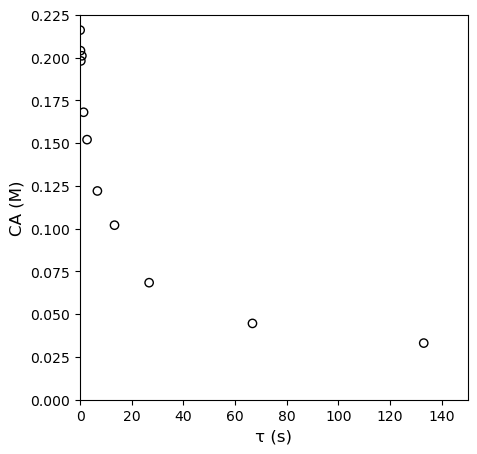

In [25]:
#####################################################################################################
# Define global constants; store experimental τ and CA in numpy arrays                              #
#####################################################################################################

CAf      = 0.209 #mol/L
# τ_exp  = np.array([0.000000000, 0.133333333, 0.266666667, 0.666666667, 1.333333333, 2.666666667, 6.666666667, 13.33333333, 26.66666667, 66.66666667, 133.3333333])
# CA_exp = np.array([0.216138658, 0.204299214, 0.198122853, 0.200721526, 0.167904995, 0.152141971, 0.12226356, 0.101508811, 0.068370453, 0.044628989, 0.033106474])

τ_exp  = np.array([0.000, 0.133, 0.267, 0.667, 1.33 , 2.670, 6.670, 13.30, 26.700, 66.700, 133.00])
CA_exp = np.array([0.216, 0.204, 0.198, 0.201, 0.168, 0.152, 0.122, 0.102, 0.0684, 0.0446, 0.0331])

#####################################################################################################
# Create scatterplot of CA vs τ data                                                                #
#####################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(τ_exp, CA_exp, marker = 'o', color = 'none', edgecolor = 'black')
plt.xlabel('τ (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 150)
plt.ylim(0, 0.225)
plt.show()

### Solution to Example Problem 02

Here we have what we would call an "integral" PFR.  By that we mean the conversion, concentration, and reaction rate change across the length of the PFR.  So, to predict the concentration measured at the exit of the PFR, we have to **integrate** the PFR material balance.  Once we do that, we can compare our predictions with the measurement, assess goodness of fit, and estimate important parameters like the reaction order and the rate constant. We have data on the effluent concentration of species $A$ at various space times, so let's start by writing a material balance on species $A$ in a PFR at steady state:

$$\frac{dF_A}{dV} = R_A$$

We have a single reaction where the coefficient on $A$ is -1, so $R_A = -r$:

$$\frac{dF_A}{dV} = -r$$

We have to address one issue: data are presented as exit concentration of $A$ measured at various **space times**, not at different reactor volumes, which is the independent variable in the current ODE. We define space time, τ, as usual:

$$\tau = \frac{V}{Q_f}$$

We are not data at various reactor volumes. There is a good reason for this.  Usually, once we fabricate a PFR, we are stuck with one PFR that has a fixed volume. It would be difficult and expensive to change the reactor volume to try to assess how the exit concentration of A changes with increasing reactor volume, so we usually do this type of experiment by varying space time instead. We do not vary space time by changing volume--that always stays fixed--so we have to do it by varying the feed volumetric flowrate, $Q_f$. We usually think of solving the PFR balance in terms of Volume, but for a kinetics experiment, it is often convenient to work with space time as the independent variable. We can accomplish this by recognizing that, for a constant density system where $Q = Q_f$, $V = \tau Q_f$.  We can make that substitution into the ODE:

$$\frac{dF_A}{d(\tau Q_f)} = -r$$

The feed volumetric flowrate is a constant, so we can move it outside of the denominator and into the numerator:

$$\frac{d(F_A/Q_f)}{d\tau} = -r$$

And we see that this gives us the concentration of species A in the numerator:

$$\frac{dC_A}{d\tau} = -r$$

That actually looks a lot like the material balance for a constant volume batch reactor! The only real difference here is that we use space time, $\tau$, instead of clock time, $t$, as our independent variable. We can then extend our method for batch reactor analysis to a PFR. Specifically, we can use differential and integral methods to analyze the data. 

#### Differential Analysis

We can use finite differences (or any other reasonable method) to estimate the derivative of $C_A$ with respect to $\tau$ from our experimental data:

$$r \approx -\frac{\Delta C_A}{\Delta \tau}$$

Doing this will generate an array of estimates for reaction rate at various values of $C_A$. For power law kinetics, we can consider a linearized form of $r$ vs. $C_A$ data:

$$\ln(r) = \ln(k) + \alpha \ln(C_A)$$

Regressing the slope and intercept of this linearization will provide us with rough estimates of the reaction order and rate constant, though we should approach cautiously as differential analysis will amplify noise in the data and may result in large confidence intervals on parameter estimates. Despite this, it remains a useful tool as it provides us with a quick way to estimate reaction orders.

```{caution}
The data here is noisy, as usual.  This results in a negative reaction rate estimated between $\tau = 0.267 \ \mathrm{s}$ and $\tau = 0.667 \ \mathrm{s}$. To use a differential analysis, we'd need to manage the data in some way. For example, we might disregard the $(C_A, r)$ pair that has a negative rate of reaction. This would allow us to proceed with the differential analysis, but we should always be cautious when excluding data from analysis. Here, we are disregarding a physically unrealistic estimate for reaction rate, but we should retain the full set of initial concentrations for subsequent use with integral analysis. 
```

From a differential analysis, we would conclude that the reaction order is $\alpha = 3.8 \pm 0.7$, suggesting that the reaction is probably either 3rd order or 4th order in species $A$. We do not have a precise estimate of the rate constant, but the analysis suggests a range of $3.5 \leq k \leq 72$. We don't have a good sense of the units yet because we cannot determine reaction order confidently.

m    =  3.80e+00 +/- 7.08e-01
b    =  2.76e+00 +/- 1.50e+00
SSE  =      1.48
SST  =     35.51
MSE  =      0.16
RMSE =      0.41
R2   =      0.96
α    =  3.80e+00 +/- 7.08e-01
k    =  1.59e+01 (but is between 3.52e+00 and 7.15e+01)


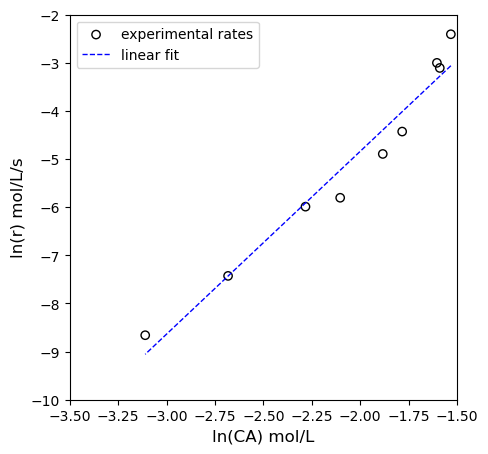

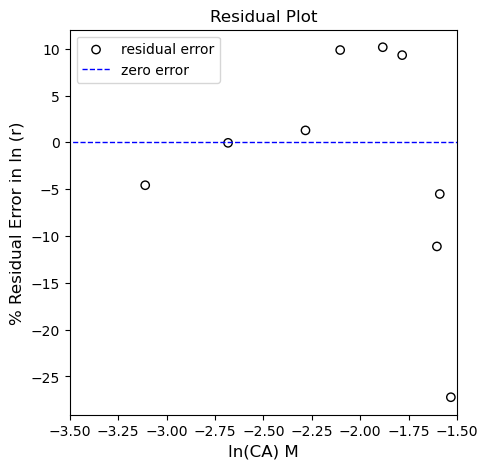

In [95]:
ΔCA   = np.diff(CA_exp)
Δτ    = np.diff(τ_exp)
r_est = -ΔCA/Δτ

i_diff = r_est >= 0
r_diff = r_est[i_diff]
C_diff = CA_exp[:-1][i_diff]

#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = np.log(r_diff)
xdata = np.log(C_diff)

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
b      = A[1]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1] 
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
SEb    = np.sqrt(COV[1, 1])           #For our definition of the X matrix, standard error in the intercept is the second diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
CIb    = SEb*tval                     #confidence interval on intercept
α      = m                            #slope is equal to the reaction order
k      = np.exp(b)                    #y intercept is equal to ln(k)

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE ,  R2, α, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2e} +/- {CIb:8.2e}')
    elif label == 'α':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:9.2e} (but is between {np.exp(b-CIb):8.2e} and {np.exp(b+CIb):8.2e})')
    else:
        print(f'{label:4s} = {value:9.2f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(-3.5, -1.5)
plt.ylim(-10.0, -2.0)
plt.xlabel('ln(CA) mol/L', fontsize = 12)
plt.ylabel('ln(r) mol/L/s', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(-3.5, -1.5)
plt.xlabel('ln(CA) M', fontsize = 12)
plt.ylabel('% Residual Error in ln (r)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper left')
plt.show()


### Integral Analysis

Alternatively, we can use an integral analysis of data. This is similar to the approach we used for batch reactors. To this point, we have always handled an integral analysis by assuming a reaction order, solving the differential equation symbolically, looking for a linear transformation, and/or using nonlinear regression to fit data to a selected model. For example:

#### First order

Rate of reaction:

$$r = kC_A$$

Material balance on A in a PFR at Steady State:

$$\frac{dC_A}{d\tau} = -kC_A$$

Solution to material balance:

$$C_A = C_{A,f}\exp{(-k \tau)}$$

Linearization:

$$\ln \left(\frac{C_A}{C_{A,f}}\right) = - k \tau$$

#### Second order

Rate of reaction:

$$r = k{C_A}^2$$

Material balance on A in a PFR at Steady State

$$\frac{dC_A}{d\tau} = -k{C_A}^2$$

Solution to material balance:

$$C_A = \left(\frac{1}{C_{A0}} + k^\prime t\right)^{-1}$$

Linearization:

$$\frac{1}{C_A} = \frac{1}{C_{A0}} + k^\prime t$$

#### Third order

$$r = k{C_A}^3$$

Material balance on A in a PFR at Steady State:

$$\frac{dC_A}{d\tau} = -k{C_A}^3$$

Solution to material balance:

$$C_A = \left(\frac{1}{{C_{A0}}^2} + 2k^\prime t\right)^{-\frac{1}{2}}$$

Linearization:

$$\frac{1}{{C_A}^2} = \frac{1}{{C_{A0}}^2} + 2k^\prime t$$

We can test any of these linearizations against our data to see which one best describes the trend. Generally, we would proceed by testing multiple reaction orders as a good fit to data is often easiest to see during comparison of several models. 

### A modified approach to integral analysis

Today we will use a variation on the method of integral analysis that we have not seen before. In this approach, we avoid guessing multiple reaction orders and we solve the ODE symbolically in terms of an unknown reaction order, $\alpha$. To use this approach, we only need to consider two solutions to the ODE:

#### First order kinetics

As shown above, if the kinetics are first order, then we know that the following solution for exit concentration will hold:

$$C_A = C_{A,f}\exp{(-k \tau)}$$

And we know we can linearize this model using natural logarithms. 

#### Unknown reaction order

We can also the material balance symbolically with an unknown reaction order, $\alpha$, where $\alpha \neq 1$:

$$\frac{dC_A}{d\tau} = -k{C_A}^\alpha$$

This is a separable ODE:

$$\frac{1}{{C_A}^\alpha}dC_A = -kd\tau$$

We then integrate both sides of that equation and apply appropriate limits:

$$\int_{C_{A,f}}^{C_A} \frac{1}{{C_A}^\alpha}dC_A = \int_0^\tau-kd\tau$$

We can solve this expression for $C_A$ to get:

$$C_A = \left[C_{A,f}^{(1 - \alpha)} - (1 - \alpha)k\tau\right]^{\left(\frac{1}{1 - \alpha}\right)}$$

It's a bit of a cumbersome equation, but it isn't ***hard*** to work with. If we think about it, this is actually a nonlinear model that describes how the concentration of species A changes as a function of residence time, $\tau$. We can therefore use that model to generate predictions of $C_A$ at various values of $\tau$. If we can do that, we can also quantify the residual sum of squares:

$$SSE = \sum_i \left(C_{A_i} - \hat{C}_{A_i}\right)^2$$

We can then use an optimization algorithm to minimze the SSE with respect to the values of $\alpha$ and $k$.  This is implemented below.

```{caution}
This model does not work for a first order reaction ($\alpha$ = 1) since the exponent on the bracketed term goes to infinity in that situation.  For that reason, we'll first test our data against a first order model to see if it is first order.
```

m    =  1.70e-02 +/- 5.33e-03
SSE  =      1.32
SST  =      4.29
MSE  =      0.12
RMSE =      0.35
R2   =      0.69
k    =  1.70e-02 +/- 5.33e-03


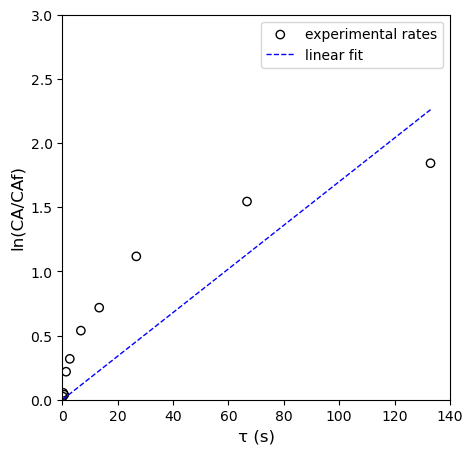

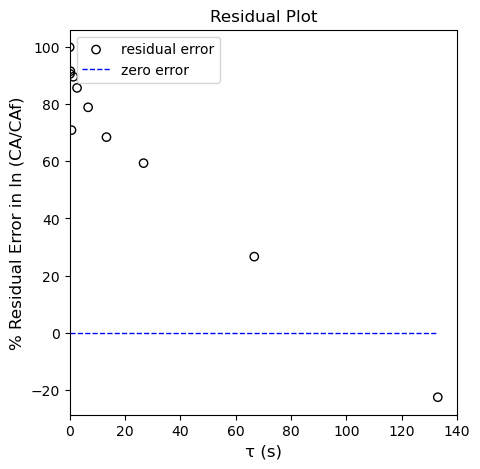

In [101]:
#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = -1*np.log(CA_exp/CAf).reshape(len(CA_exp))
xdata = τ_exp.reshape(len(τ_exp),1)

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = xdata

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
k      = m                            #y intercept is equal to ln(k)

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'SSE', 'SST','MSE','RMSE', 'R2', 'k']
values = [m  ,  SSE1,  SST , MSE , RMSE ,  R2 ,  k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2e} +/- {CIb:8.2e}')
    elif label == 'α':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    else:
        print(f'{label:4s} = {value:9.2f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(0, 140)
plt.ylim(0, 3.0)
plt.xlabel('τ (s)', fontsize = 12)
plt.ylabel('ln(CA/CAf)', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(0, 140)
plt.xlabel('τ (s)', fontsize = 12)
plt.ylabel('% Residual Error in ln (CA/CAf)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper left')
plt.show()

That isn't even close, but this is the "best fit" straight line with a zero y-intercept that goes through our data. This definitely isn't a first order reaction, so let's return to the generic model:

$$C_A = \left[ C_{A,f}^{(1 - \alpha)} - (1 - \alpha)k\tau\right]^{\left(\frac{1}{1 - \alpha}\right)}$$

First, we'll write a function that will calculate the model prediction for $C_A$ at various values of $k$, $\alpha$, and $\tau$:

In [103]:
def CA_mod(k, α, τ):
    CA  = (CAf**(1 - α) - (1 - α)*k*τ)**(1/(1 - α))
    return CA

With this function in hand, we can solve for model predictions given any values for the arguments $(k, \alpha, \tau)$. Next, we assume some values of the function arguments to see how well the model fits the data.

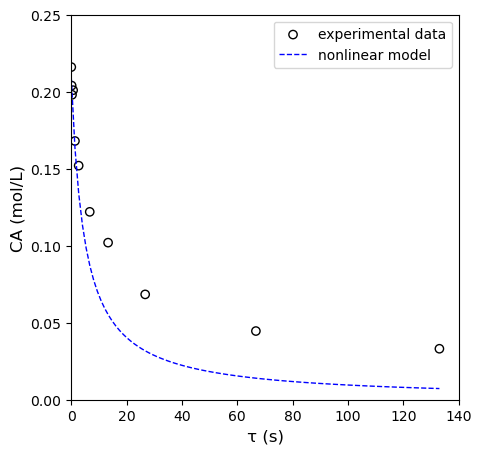

In [114]:
kguess = 1
αguess = 2
τset   = np.linspace(0, max(τ_exp), 100)
plt.figure(1, figsize = (5, 5))
plt.scatter(τ_exp, CA_exp, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(τset, CA_mod(kguess, αguess, τset), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'nonlinear model')
plt.xlabel('τ (s)', fontsize = 12)
plt.ylabel('CA (mol/L)', fontsize = 12)
plt.xlim(0, 140.0)
plt.ylim(0, 0.25)
plt.legend()
plt.show()

OK, that's not a bad fit, but it probably also isn't the best fit.  We can do better if we write an objective function and use an optimization algorithm to solve for the best fit values of k and alpha.  We'll do that below.

In [115]:
def OBJ(par):
    k, α = par
    CA_pred = CA_mod(k, α, τ_exp)
    SSE     = np.sum((CA_exp - CA_pred)**2)
    return SSE

par0   = [1, 3]
answer = opt.minimize(OBJ, par0)
print(answer, '\n')
k_opt = answer.x[0]
a_opt = answer.x[1]
CA_pred = CA_mod(k_opt, a_opt, tau_exp)

print(f'k = {k_opt:3.3f}, α = {a_opt:3.3f}')

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00032385137527702446
        x: [ 3.910e+00  3.072e+00]
      nit: 26
      jac: [-1.260e-07  7.471e-07]
 hess_inv: [[ 4.105e+04  5.126e+03]
            [ 5.126e+03  6.581e+02]]
     nfev: 90
     njev: 30 

k = 3.910, α = 3.072


Now that we have optimum parameters, we'll overlay the optimum fit with our experimental data and see how it does.

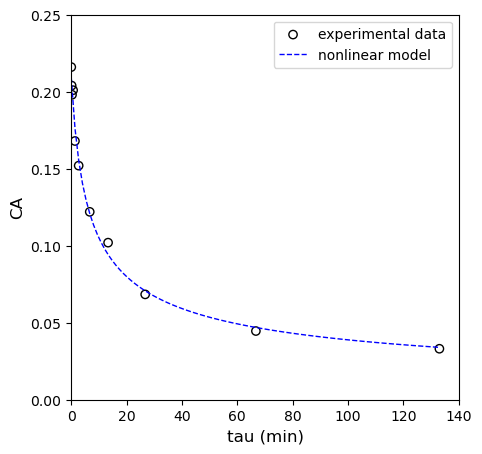

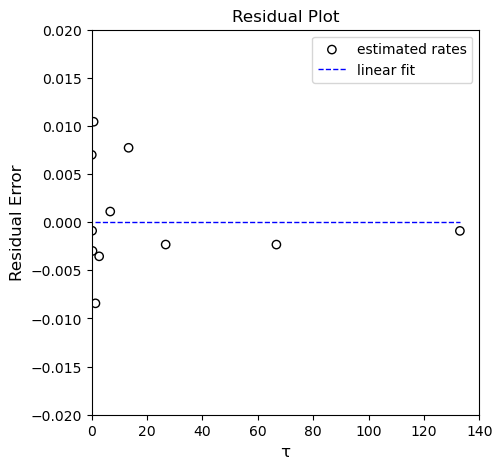

In [116]:
plt.figure(1, figsize = (5, 5))
plt.scatter(tau_exp, CA_exp, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(tauset, CA_mod(k_opt, a_opt, tauset), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'nonlinear model')
plt.xlabel('tau (min)', fontsize = 12)
plt.ylabel('CA', fontsize = 12)
plt.xlim(0, 140.0)
plt.ylim(0, 0.25)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(tau_exp, (CA_exp - CA_pred), marker = 'o', color = 'none', edgecolor = 'black', label = 'estimated rates')
plt.hlines(0, 1, ceil(max(tau_exp)), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('τ', fontsize = 12)
plt.ylabel('Residual Error', fontsize = 12)
plt.title('Residual Plot')
plt.xlim(0, 140.0)
plt.ylim(-0.02, 0.02)
plt.legend()
plt.show()

### Linearizing the third order fit

Looks like a great fit!!!  We are thus reasonably confident that our optimized parameter values along with the nonlinear model do a good job of capturing the data.  Based on that, I'd suggest that the reaction is 3rd order.  In general, we have to recognize that the precision of each estimated parameter decreases when we increase the number of parameters estimated. The most precise estimate of the rate constant would be giving by then solving the material balance for third order kinetics:

$$\frac{dC_A}{d\tau} = -k{C_A}^3$$

This would give:

$$\frac{1}{2{C_A}^2} = \frac{1}{2{C_{A,f}}^2} + k \tau$$

We could use that linearization to regress the rate constant

m    = 3.39e+00 +/- 1.01e-01
SSE  = 313.18
SST  = 199493.82
MSE  = 28.47
RMSE = 5.34
R2   = 1.00
k    = 3.39e+00 +/- 1.01e-01


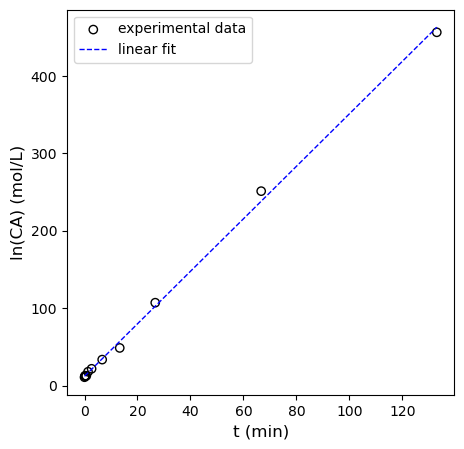

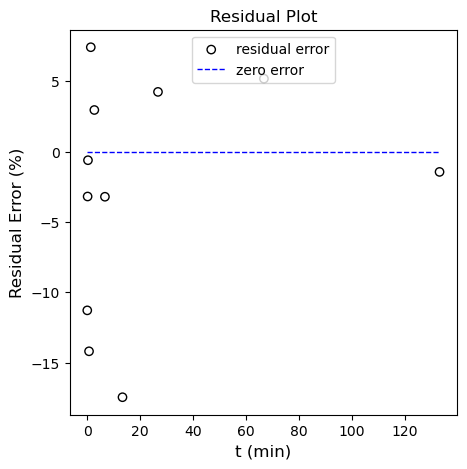

In [13]:
ydata  = 1/2/CA_exp**2
xdata  = tau_exp
Y      = ydata
X      = np.vander(xdata, 2)
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                  #slope of best fit line
# b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
# SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
# CIb   = SEb*tval              #95% confidence interval on y-intercept
k     = m
# CA0   = np.exp(b)
labels = ['m', 'SSE', 'SST','MSE','RMSE', 'R2', 'k']
values = [m  ,  SSE ,  SST , MSE , RMSE ,  R2, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    else:
        print(f'{label:4s} = {value:0.2f}')
        
plt.figure(1, figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('ln(CA) (mol/L)', fontsize = 12)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper center')
plt.show()

### Forcing the intercept to improve precision


I prefer the following since it avoids estimation of a y-intercept and improves our precision on the slope.

$$\frac{1}{2{C_A}^2} - \frac{1}{2{C_{A,f}}^2} =  + k \tau$$

So in this linearization, we'd plot:

$\frac{1}{2{C_A}^2} - \frac{1}{2{C_{A,f}}^2}$ vs. $\tau$.  The slope of that line is your rate constant.

m    = 3.39e+00 +/- 8.23e-02
SSE  = 314.96
SST  = 199493.82
MSE  = 28.63
RMSE = 5.35
R2   = 1.00
k    = 3.39e+00 +/- 8.23e-02


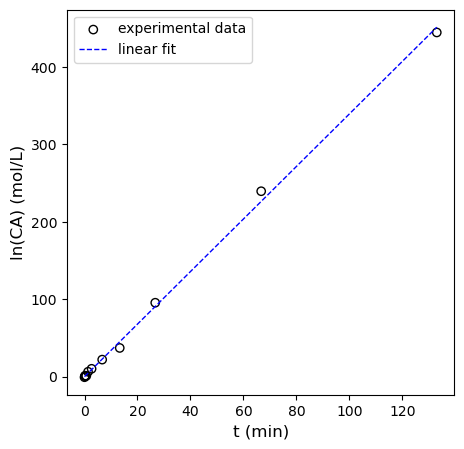

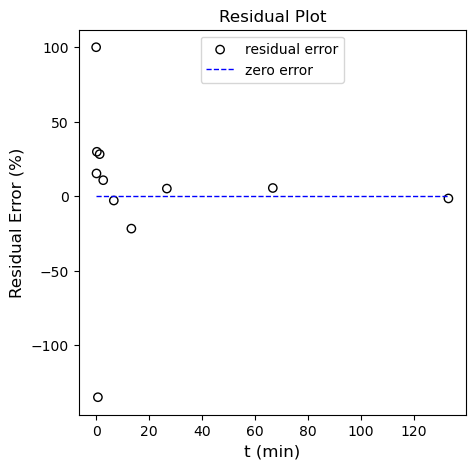

In [14]:
ydata = (1/2/CA_exp**2 - 1/2/CAf**2)
xdata = tau_exp

Y     = ydata
X     = tau_exp.reshape(len(tau_exp),1)
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                  #slope of best fit line
# b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
# SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
# CIb   = SEb*tval              #95% confidence interval on y-intercept
k     = m
# CA0   = np.exp(b)
labels = ['m', 'SSE', 'SST','MSE','RMSE', 'R2', 'k']
values = [m  ,  SSE ,  SST , MSE , RMSE ,  R2, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    else:
        print(f'{label:4s} = {value:0.2f}')
        
plt.figure(1, figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('ln(CA) (mol/L)', fontsize = 12)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper center')
plt.show()